In [126]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import csv
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Now you can access your environment variables
host = os.getenv('DB_HOST')
database = os.getenv('DB_NAME')
password = os.getenv('DB_PASSWORD')
user = os.getenv('DB_USER')
port = os.getenv('DB_PORT')

In [127]:
# Test Connection to HotelCloud RDS 
try:
    connection = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port=port
    )
    
    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()
    
    # Example: Execute a simple query
    cursor.execute("SELECT version();")
     
    # Fetch the result
    db_version = cursor.fetchone()
    print(f"PostgreSQL database version: {db_version}")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

finally:
    # Close the cursor and connection
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL database version: ('PostgreSQL 16.1 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)
PostgreSQL connection is closed


In [24]:
#Check Booking channel names and filter for all channels that include booking.com
try:
    connection = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port=port
    )
    
    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()
    
    # Example: Execute a simple query
    cursor.execute("SELECT DISTINCT booking_channel_name FROM booking WHERE booking_channel_name ILIKE '%booking.com%' ORDER BY booking_channel_name;")
    booking_channel_names = cursor.fetchall()

    print(booking_channel_names)
    
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

finally:
    # Close the cursor and connection
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

[('booking.com',), ('Booking.com',), ('Booking.Com',), ('Booking.Com ',), ('BOOKING.COM',), ('BOOKING.COM ',), ('booking.com bv',), ('Booking.com B.V.',), ('BOOKING.COM BV (EUR NL)',), ('Booking.com Limited',), ('BOOKING.COM-NOCOMMINBESTCHEQUE',), ('Booking.com (Old)',), ('Booking.comVCC',), ('Booking.com VCC',), ('booking.com (Virtual card',), ('Import/Booking.com',), ('Worldwide Booking.com - Guestlink',)]
PostgreSQL connection is closed


In [25]:
#Check all rate codes for all booking.com channels
try:
    connection = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port=port
    )
    
    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()
    
    # Example: Execute a simple query
    cursor.execute("SELECT DISTINCT rate_plan_code FROM booking ORDER BY rate_plan_code;")
    rate_codes = cursor.fetchall()

    print(rate_codes)
    
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

finally:
    # Close the cursor and connection
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

[('',), (']',), ('000',), ('0000',), ('07092024',), ('100_XMAS',), ('101_UPGRADE',), ('109_BBB',), ('109_DINE',), ('10K_FULL_21',), ('10OFF',), ('10% off Advance Purchase Rate',), ('10% off Advance Purchase Rate Room Only',), ('10% off Best Available Rate',), ('10% off Best Available Rate Room Only',), ('10_RACK_BB',), ("111-Ria's Business rate",), ('111-Rias leisure',), ('119_DBB',), ('120_STAY_FRE',), ('12995_24HR',), ('12DDR',), ('139_DBB',), ('139_SD',), ('£140.00 Corp',), ('145 + VAT INC EB',), ('149BB',), ('149_DBB',), ('£150.00 Corp',), ('155BBIN',), ('159_DBB',), ('159_SD',), ('15_BB',), ('15COVIDPACKA',), ('15OFF',), ('15% off Advance Purchase Rate',), ('15% off Advance Purchase Rate Room Only',), ('15% off Best Available Rate Room Only',), ('15_RO',), ('£160.00 Corp',), ('169DATENIGHT',), ('18APRFUNC',), ('195BB',), ('1995PP',), ('19MTEU',), ('1. BB (db/tb) 2010',), ('1. BB (db/tb) 2011',), ('1. BB (s/o) 2010',), ('1. BB (s/o) 2011',), ('1GOLF_20',), ('1N2RBBMF',), ('1N2RBBMF

In [26]:
#Read in data from all booking.com channels with rate code FLRA1

SQL_QUERY = """
WITH rate_updates AS (
    SELECT DISTINCT ON (u.hotel_id, u.date_update::date)
        u.hotel_id,
        u.rate_update_id,
        u.date_update::date AS report_date
    FROM rate_update u
    WHERE
        u.hotel_id = 6
        AND u.date_update::date >= '2022-05-01'
        AND u.date_update::date < current_date
    ORDER BY u.hotel_id, u.date_update::date, u.date_update DESC
),

-- Subquery 2: ota_rooms
-- This subquery gathers information about rooms available on Online Travel Agencies (OTAs)
ota_rooms AS (
    SELECT DISTINCT
        o.ota_room_id,
        r."name",
        o.room_id
    FROM ota_room o
    JOIN room r ON r.room_id = o.room_id
    LEFT OUTER JOIN room_category rc ON rc.room_category_id = r.room_category_id
    WHERE o.hotel_id = 6
),

-- Subquery 3: rate_data
-- This subquery collects rate information for rooms, including refundable and non-refundable rates
rate_data AS (
    SELECT
        MIN(CASE WHEN r.refundable THEN r.amount END) AS refundable_rate,
        MIN(CASE WHEN NOT r.refundable THEN r.amount END) AS non_refundable_rate,
        u.hotel_id,
        u.report_date,
        r.stay_date,
        o.name AS room_name,
        r.adultcount
    FROM
        rate_new r
    JOIN
        rate_updates u ON r.rate_update_id = u.rate_update_id
    JOIN
        ota_rooms o ON o.ota_room_id = r.ota_room_id
    GROUP BY
        u.hotel_id,
        u.report_date,
        r.stay_date,
        o.name,
        r.adultcount
),

-- Subquery 4: booking
-- This subquery gathers detailed booking information, including guest details, room information, and financial data
booking AS (
    SELECT
        p.first_name,
        p.last_name,
        b.hotel_id,
        b.room_id,
        b.created_date::date AS created_date,
        b.check_in,
        b.check_out, 
        b.cancel_date::date AS cancel_date,
        b.booking_reference, 
        EXTRACT(DAY FROM (dt."date" - b.created_date::date)) AS lead_in,
        b.booking_channel_name,
        b.booking_status, 
        b.adults,
        b.rate_plan_code,
        b.nights,
        b.room_revenue,
        ROUND(COALESCE(br.total_revenue, b.total_revenue / NULLIF(b.nights, 0)),2) AS total_revenue_x,
        Round(b.total_revenue * 1.2) as exp_rate,
        b.total_revenue_after_tax,
        h."name" AS hotel_name,
        r."name" AS room_name,
        r.code as room_code,
        dt."date" AS stay_date
    FROM
        booking b
    JOIN profile p ON b.profile_id = p.profile_id
    JOIN hotel h ON b.hotel_id = h.hotel_id
    JOIN room r ON b.room_id = r.room_id
    JOIN caldate dt ON b.check_in <= dt."date"
        AND (b.check_out > dt."date" OR (b.check_in = b.check_out AND dt."date" = b.check_in))
    LEFT JOIN booking_rate br ON b.booking_id = br.booking_rate_id
    WHERE
        b.created_date >= '2022-01-01'
        AND b.hotel_id = '6'
        AND b.booking_channel_name IN (
 'booking.com', 'Booking.com', 'Booking.Com', 'Booking.Com ', 'BOOKING.COM',
 'BOOKING.COM ', 'booking.com bv', 'Booking.com B.V.', 'BOOKING.COM BV (EUR NL)',
 'Booking.com Limited', 'BOOKING.COM-NOCOMMINBESTCHEQUE', 'Booking.com (Old)',
 'Booking.comVCC', 'Booking.com VCC', 'booking.com (Virtual card',
 'Import/Booking.com', 'Worldwide Booking.com - Guestlink'
)
        AND b.nights = 1
        AND b.rate_plan_code = 'FLRA1'
)

-- Main Query
-- This part combines the booking data with the rate data and filters for discrepancies between expected and actual rates
SELECT b.*, r.*
FROM booking AS b
JOIN caldate dt ON b.check_in <= dt."date"
    AND (b.check_out > dt."date" OR (b.check_in = b.check_out AND dt."date" = b.check_in))
LEFT JOIN rate_data AS r ON r.adultcount = b.adults 
    AND r.room_name = b.room_name 
    AND b.created_date = r.report_date 
    AND dt.date = r.stay_date
WHERE b.exp_rate <> r.refundable_rate
ORDER BY b.nights ASC;
"""


try:
    connection = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password,
        port=port
    )
    
    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()
    
    # Example: Execute a simple query
    cursor.execute(SQL_QUERY)
    results = cursor.fetchall()

    column_names = [desc[0] for desc in cursor.description]

    filename = f"full_rates_data.csv"

    # Write to CSV
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        # Write header
        csvwriter.writerow(column_names)
        
        # Write data rows
        csvwriter.writerows(results)

    print(f"Data has been written to {filename}")

    
except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

finally:
    # Close the cursor and connection
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

Data has been written to full_rates_data.csv
PostgreSQL connection is closed


In [30]:
filtered_rates_data = pd.read_csv('full_rates_data.csv')
# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(f"Number of rows: {len(filtered_rates_data)}")

filtered_rates_data.head()

Number of rows: 1477


,first_name,last_name,hotel_id,room_id,created_date,check_in,check_out,cancel_date,booking_reference,lead_in,booking_channel_name,booking_status,adults,rate_plan_code,nights,room_revenue,total_revenue_x,exp_rate,total_revenue_after_tax,hotel_name,room_name,room_code,stay_date,refundable_rate,non_refundable_rate,hotel_id.1,report_date,stay_date.1,room_name.1,adultcount
0,Aidan,Darcy,6,127,2022-06-29,2022-10-01,2022-10-02,NaN,376297932,94,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,232.12,232.12,279,278.54,Mercure Hyde Park,Standard King,KGC,2022-10-01 00:00:00,309.0,NaN,6,2022-06-29,2022-10-01,Standard King,2
1,Maciej,Madejak,6,125,2022-05-07,2022-05-09,2022-05-10,2022-05-09,375274226,2,BOOKING.COM BV (EUR NL),Cancelled,1,FLRA1,1,0.00,0.00,0,0.00,Mercure Hyde Park,Family Room,TRB,2022-05-09 00:00:00,369.0,NaN,6,2022-05-07,2022-05-09,Family Room,1
2,Sophie,Wadden,6,127,2022-08-01,2022-09-18,2022-09-19,NaN,376923042,48,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,172.12,172.12,207,206.54,Mercure Hyde Park,Standard King,KGC,2022-09-18 00:00:00,229.0,209.0,6,2022-08-01,2022-09-18,Standard King,2
3,Lydia,Johnson,6,127,2022-08-01,2022-08-12,2022-08-13,NaN,376915764,11,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,209.62,209.62,252,251.54,Mercure Hyde Park,Standard King,KGC,2022-08-12 00:00:00,279.0,249.0,6,2022-08-01,2022-08-12,Standard King,2
4,Sharifah,Iyliana,6,127,2022-08-01,2022-08-21,2022-08-22,NaN,377289468,20,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,142.12,142.12,171,170.54,Mercure Hyde Park,Standard King,KGC,2022-08-21 00:00:00,199.0,189.0,6,2022-08-01,2022-08-21,Standard King,2


In [31]:
rates_comparison_df = filtered_rates_data[['booking_reference', 'room_revenue', 'total_revenue_after_tax', 'refundable_rate']]
rates_comparison_df.head()

,booking_reference,room_revenue,total_revenue_after_tax,refundable_rate
0,376297932,232.12,278.54,309.0
1,375274226,0.00,0.00,369.0
2,376923042,172.12,206.54,229.0
3,376915764,209.62,251.54,279.0
4,377289468,142.12,170.54,199.0


In [32]:
#Calculate total revenue after taxes and discount
#Tax + Discount = 10% off (Genius Level 1)
rates_comparison_df['total_revenue_after_tax_and_discount'] = rates_comparison_df['room_revenue']*1.2/0.9
#Tax + 2 Discounts => 10% off (Genius Level 1) + 10% off (App Discount)
rates_comparison_df['total_revenue_after_tax_and_two_discounts'] = rates_comparison_df['room_revenue']*1.2/0.81
#Tax + Discount = 15% off (Genius Level 2)
rates_comparison_df['total_revenue_after_tax_and_discount_g2'] = rates_comparison_df['room_revenue']*1.2/0.85
rates_comparison_df['total_revenue_after_tax_and_discount_g2_and_app_discount'] = rates_comparison_df['room_revenue']*1.2/0.765
#Tax + Discount = 20% off (Genius Level 3)
rates_comparison_df['total_revenue_after_tax_and_discount_g3'] = rates_comparison_df['room_revenue']*1.2/0.80
rates_comparison_df['total_revenue_after_tax_and_discount_g3_and_app_discount'] = rates_comparison_df['room_revenue']*1.2/0.72

/var/folders/7m/8y6jbsj56511tmcdmrpyjlrr0000gn/T/ipykernel_74426/2421277455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rates_comparison_df['total_revenue_after_tax_and_discount'] = rates_comparison_df['room_revenue']*1.2/0.9
/var/folders/7m/8y6jbsj56511tmcdmrpyjlrr0000gn/T/ipykernel_74426/2421277455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rates_comparison_df['total_revenue_after_tax_and_two_discounts'] = rates_comparison_df['room_revenue']*1.2/0.81
/var/folders/7m/8y6jbsj56511tmcdmrpyjl

In [33]:
rates_comparison_df.head()

,booking_reference,room_revenue,total_revenue_after_tax,refundable_rate,total_revenue_after_tax_and_discount,total_revenue_after_tax_and_two_discounts,total_revenue_after_tax_and_discount_g2,total_revenue_after_tax_and_discount_g2_and_app_discount,total_revenue_after_tax_and_discount_g3,total_revenue_after_tax_and_discount_g3_and_app_discount
0,376297932,232.12,278.54,309.0,309.493333,343.881481,327.698824,364.109804,348.18,386.866667
1,375274226,0.00,0.00,369.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,376923042,172.12,206.54,229.0,229.493333,254.992593,242.992941,269.992157,258.18,286.866667
3,376915764,209.62,251.54,279.0,279.493333,310.548148,295.934118,328.815686,314.43,349.366667
4,377289468,142.12,170.54,199.0,189.493333,210.548148,200.640000,222.933333,213.18,236.866667


In [34]:
# Check for matches and mismatches between total revenue after taxes and discount and refundable rate
match_after_tax_and_discount = np.isclose(rates_comparison_df['total_revenue_after_tax_and_discount'], rates_comparison_df['refundable_rate'], atol=1)
num_matches_tax_discount = match_after_tax_and_discount.sum()
num_mismatches_tax_discount = (~match_after_tax_and_discount).sum()

print(f"Comparison of total revenue after tax and Genius Level 1 discount with refundable rate:")
print(f"Number of matches: {num_matches_tax_discount}, Percentage of matches: {num_matches_tax_discount/len(rates_comparison_df)*100}")
print(f"Number of mismatches: {num_mismatches_tax_discount}")

# Check for matches and mismatches between total revenue after taxes and two discounts and refundable rate
match_after_tax_and_two_discounts = np.isclose(rates_comparison_df['total_revenue_after_tax_and_two_discounts'], rates_comparison_df['refundable_rate'], atol=1)
num_matches_tax_two_discounts = match_after_tax_and_two_discounts.sum()
num_mismatches_tax_two_discounts = (~match_after_tax_and_two_discounts).sum()

print(f"\nComparison of total revenue after tax and Genius Level 1 discount and App Discount with refundable rate:")
print(f"Number of matches: {num_matches_tax_two_discounts}, Percentage of matches: {num_matches_tax_two_discounts/len(rates_comparison_df)*100}")
print(f"Number of mismatches: {num_mismatches_tax_two_discounts}")

# Check for matches and mismatches between total revenue after taxes and discount and refundable rate
match_after_tax_and_discount_g2 = np.isclose(rates_comparison_df['total_revenue_after_tax_and_discount_g2'], rates_comparison_df['refundable_rate'], atol=1)
num_matches_tax_discount_g2 = match_after_tax_and_discount_g2.sum()
num_mismatches_tax_discount_g2 = (~match_after_tax_and_discount_g2).sum()

print(f"\nComparison of total revenue after tax and Genius Level 2 discount with refundable rate:")
print(f"Number of matches: {num_matches_tax_discount_g2}, Percentage of matches: {num_matches_tax_discount_g2/len(rates_comparison_df)*100}")
print(f"Number of mismatches: {num_mismatches_tax_discount_g2}")

match_after_tax_and_discount_g2_and_app_discount = np.isclose(rates_comparison_df['total_revenue_after_tax_and_discount_g2_and_app_discount'], rates_comparison_df['refundable_rate'], atol=1)
num_matches_tax_discount_g2_and_app_discount = match_after_tax_and_discount_g2_and_app_discount.sum()
num_mismatches_tax_discount_g2_and_app_discount = (~match_after_tax_and_discount_g2_and_app_discount).sum()

print(f"\nComparison of total revenue after tax and Genius Level 2 discount and App Discount with refundable rate:")
print(f"Number of matches: {num_matches_tax_discount_g2_and_app_discount}, Percentage of matches: {num_matches_tax_discount_g2_and_app_discount/len(rates_comparison_df)*100}")
print(f"Number of mismatches: {num_mismatches_tax_discount_g2_and_app_discount}")


match_after_tax_and_discount_g3 = np.isclose(rates_comparison_df['total_revenue_after_tax_and_discount_g3'], rates_comparison_df['refundable_rate'], atol=1)
num_matches_tax_discount_g3 = match_after_tax_and_discount_g3.sum()
num_mismatches_tax_discount_g3 = (~match_after_tax_and_discount_g3).sum()

print(f"\nComparison of total revenue after tax and Genius Level 3 discount with refundable rate:")
print(f"Number of matches: {num_matches_tax_discount_g3}, Percentage of matches: {num_matches_tax_discount_g3/len(rates_comparison_df)*100}")
print(f"Number of mismatches: {num_mismatches_tax_discount_g3}")

match_after_tax_and_discount_g3_and_app_discount = np.isclose(rates_comparison_df['total_revenue_after_tax_and_discount_g3_and_app_discount'], rates_comparison_df['refundable_rate'], atol=1)
num_matches_tax_discount_g3_and_app_discount = match_after_tax_and_discount_g3_and_app_discount.sum()
num_mismatches_tax_discount_g3_and_app_discount = (~match_after_tax_and_discount_g3_and_app_discount).sum()

print(f"\nComparison of total revenue after tax and Genius Level 3 discount and App Discount with refundable rate:")
print(f"Number of matches: {num_matches_tax_discount_g3_and_app_discount}, Percentage of matches: {num_matches_tax_discount_g3_and_app_discount/len(rates_comparison_df)*100}")
print(f"Number of mismatches: {num_mismatches_tax_discount_g3_and_app_discount}, Percentage of mismatches: {num_mismatches_tax_discount_g3_and_app_discount/len(rates_comparison_df)*100}")


Comparison of total revenue after tax and Genius Level 1 discount with refundable rate:
Number of matches: 93, Percentage of matches: 6.296547054840894
Number of mismatches: 1384

Comparison of total revenue after tax and Genius Level 1 discount and App Discount with refundable rate:
Number of matches: 79, Percentage of matches: 5.348679756262695
Number of mismatches: 1398

Comparison of total revenue after tax and Genius Level 2 discount with refundable rate:
Number of matches: 18, Percentage of matches: 1.2186865267433988
Number of mismatches: 1459

Comparison of total revenue after tax and Genius Level 2 discount and App Discount with refundable rate:
Number of matches: 35, Percentage of matches: 2.3696682464454977
Number of mismatches: 1442

Comparison of total revenue after tax and Genius Level 3 discount with refundable rate:
Number of matches: 18, Percentage of matches: 1.2186865267433988
Number of mismatches: 1459

Comparison of total revenue after tax and Genius Level 3 discou

In [35]:
# Create boolean masks for matches
match_refundable_vs_tax_discount = np.isclose(rates_comparison_df['refundable_rate'], 
                                              rates_comparison_df['total_revenue_after_tax_and_discount'], 
                                              atol=1)

match_refundable_vs_tax_two_discounts = np.isclose(rates_comparison_df['refundable_rate'], 
                                                   rates_comparison_df['total_revenue_after_tax_and_two_discounts'], 
                                                   atol=1)

match_refundable_vs_tax_discount_g2 = np.isclose(rates_comparison_df['refundable_rate'], 
                                                   rates_comparison_df['total_revenue_after_tax_and_discount_g2'], 
                                                   atol=1)

match_refundable_vs_tax_discount_g2_and_app_discount = np.isclose(rates_comparison_df['refundable_rate'], 
                                                   rates_comparison_df['total_revenue_after_tax_and_discount_g2_and_app_discount'], 
                                                   atol=1)  

match_refundable_vs_tax_discount_g3 = np.isclose(rates_comparison_df['refundable_rate'], 
                                                   rates_comparison_df['total_revenue_after_tax_and_discount_g3'], 
                                                   atol=1)

match_refundable_vs_tax_discount_g3_and_app_discount = np.isclose(rates_comparison_df['refundable_rate'], 
                                                   rates_comparison_df['total_revenue_after_tax_and_discount_g3_and_app_discount'], 
                                                   atol=1)




# Create a mask for all mismatches
all_mismatches = (~match_refundable_vs_tax_discount) & (~match_refundable_vs_tax_two_discounts) & (~match_refundable_vs_tax_discount_g2) & (~match_refundable_vs_tax_discount_g2_and_app_discount) & (~match_refundable_vs_tax_discount_g3) & (~match_refundable_vs_tax_discount_g3_and_app_discount)

# Create a DataFrame with all mismatches
mismatches_df = rates_comparison_df[all_mismatches]

# Print summary
print(f"Total number of rows: {len(rates_comparison_df)}")
print(f"Number of mismatches (not matching single or double discounts): {len(mismatches_df)}")

# Round numeric columns to the nearest integer
numeric_columns = mismatches_df.select_dtypes(include=[np.number]).columns
mismatches_df_rounded = mismatches_df.copy()
mismatches_df_rounded[numeric_columns] = mismatches_df_rounded[numeric_columns].round().astype(int)

# Display the first few rows of the mismatches DataFrame with rounded values
print("\nFirst few rows of all mismatches (values rounded to nearest integer):")
mismatches_df_rounded.head()


Total number of rows: 1477
Number of mismatches (not matching single or double discounts): 1220

First few rows of all mismatches (values rounded to nearest integer):


,booking_reference,room_revenue,total_revenue_after_tax,refundable_rate,total_revenue_after_tax_and_discount,total_revenue_after_tax_and_two_discounts,total_revenue_after_tax_and_discount_g2,total_revenue_after_tax_and_discount_g2_and_app_discount,total_revenue_after_tax_and_discount_g3,total_revenue_after_tax_and_discount_g3_and_app_discount
1,375274226,0,0,369,0,0,0,0,0,0
4,377289468,142,171,199,189,211,201,223,213,237
5,376918586,142,171,199,189,211,201,223,213,237
6,376918600,183,219,279,244,271,258,287,274,305
7,379446051,128,153,199,171,189,181,201,192,213


In [36]:
def ends_with_9(x):
    return np.abs(x % 10 - 9) < 0.1 # Using a small threshold to account for floating-point precision
# Create boolean masks for each condition
ends_9_after_tax = ends_with_9(rates_comparison_df['total_revenue_after_tax'])
ends_9_after_tax_discount = ends_with_9(rates_comparison_df['total_revenue_after_tax_and_discount'])
ends_9_after_tax_two_discounts = ends_with_9(rates_comparison_df['total_revenue_after_tax_and_two_discounts'])
ends_9_after_tax_discount_g2 = ends_with_9(rates_comparison_df['total_revenue_after_tax_and_discount_g2'])
ends_9_after_tax_discount_g2_and_app_discount = ends_with_9(rates_comparison_df['total_revenue_after_tax_and_discount_g2_and_app_discount'])
ends_9_after_tax_discount_g3 = ends_with_9(rates_comparison_df['total_revenue_after_tax_and_discount_g3'])
ends_9_after_tax_discount_g3_and_app_discount = ends_with_9(rates_comparison_df['total_revenue_after_tax_and_discount_g3_and_app_discount'])
# Combine the masks
any_ends_with_9 = ends_9_after_tax | ends_9_after_tax_discount | ends_9_after_tax_two_discounts | ends_9_after_tax_discount_g2 | ends_9_after_tax_discount_g2_and_app_discount | ends_9_after_tax_discount_g3 | ends_9_after_tax_discount_g3_and_app_discount
# Create the new DataFrame for possible upgrades
possible_upgrades_df = rates_comparison_df[any_ends_with_9]
# Print summary
print(f"Number of possible upgrades (i.e. ending with 9): {len(possible_upgrades_df)}")
# Round the displayed values to 2 decimal places for clarity
upgrades_display = possible_upgrades_df[['booking_reference', 'total_revenue_after_tax',
'total_revenue_after_tax_and_discount',
'total_revenue_after_tax_and_two_discounts']].round()
print("\nFirst few rows of possible upgrades (rounded to 2 decimal places):")
upgrades_display.head()

Number of possible upgrades (i.e. ending with 9): 24

First few rows of possible upgrades (rounded to 2 decimal places):


,booking_reference,total_revenue_after_tax,total_revenue_after_tax_and_discount,total_revenue_after_tax_and_two_discounts
14,595939158056,791.0,879.0,977.0
55,380175627,307.0,341.0,379.0
155,375522882,404.0,449.0,499.0
231,595939028806,341.0,379.0,421.0
234,595939565149,307.0,341.0,379.0


In [38]:
df1 = pd.read_csv('matches_after_tax.csv')
df2 = pd.read_csv('full_rates_data.csv')
complete_rates_data = pd.concat([df1, df2], axis=0)

In [81]:
complete_rates_data.head()

,first_name,last_name,hotel_id,room_id,created_date,check_in,check_out,cancel_date,booking_reference,lead_in,booking_channel_name,booking_status,adults,rate_plan_code,nights,room_revenue,total_revenue_x,exp_rate,total_revenue_after_tax,hotel_name,room_name,room_code,stay_date,refundable_rate,non_refundable_rate,hotel_id-2,report_date,stay_date-2,room_name-2,adultcount,hotel_id.1,stay_date.1,room_name.1,total_revenue_after_tax_and_discount,total_revenue_after_tax_and_two_discounts,total_revenue_after_tax_and_discount_g2,total_revenue_after_tax_and_discount_g2_and_app_discount,total_revenue_after_tax_and_discount_g3,total_revenue_after_tax_and_discount_g3_and_app_discount
0,Fredrika,Granath,6,125,2022-05-01,2022-06-27,2022-06-28,NaN,375146984,57,BOOKING.COM BV (EUR NL),CheckedOut,3,FLRA1,1,291.24,291.24,349,349.49,Mercure Hyde Park,Family Room,TRB,2022-06-27 00:00:00,349.0,319.0,6.0,2022-05-01,2022-06-27,Family Room,3,NaN,NaN,NaN,388.320000,431.466667,411.162353,456.847059,436.860,485.400000
1,Michael,McNeill,6,128,2022-05-03,2022-05-14,2022-05-15,NaN,375182494,11,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,266.24,266.24,319,319.49,Mercure Hyde Park,Standard Twin,TWC,2022-05-14 00:00:00,319.0,289.0,6.0,2022-05-03,2022-05-14,Standard Twin,2,NaN,NaN,NaN,354.986667,394.429630,375.868235,417.631373,399.360,443.733333
2,claire,White,6,124,2022-05-04,2022-08-13,2022-08-14,NaN,375209446,101,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,382.91,382.91,459,459.49,Mercure Hyde Park,Suite with 1 King-Size Bed,KSB,2022-08-13 00:00:00,459.0,429.0,6.0,2022-05-04,2022-08-13,Suite with 1 King-Size Bed,2,NaN,NaN,NaN,510.546667,567.274074,540.578824,600.643137,574.365,638.183333
3,Joe,Caygill,6,128,2022-05-15,2022-07-01,2022-07-02,NaN,375431351,47,Booking.com VCC,CheckedOut,2,FLRA1,1,341.24,341.24,409,409.49,Mercure Hyde Park,Standard Twin,TWC,2022-07-01 00:00:00,409.0,NaN,6.0,2022-05-15,2022-07-01,Standard Twin,2,NaN,NaN,NaN,454.986667,505.540741,481.750588,535.278431,511.860,568.733333
4,Abbeygail,Beaumont,6,127,2022-05-22,2022-08-29,2022-08-30,NaN,375567241,99,Booking.com VCC,CheckedOut,2,FLRA1,1,166.24,166.24,199,199.49,Mercure Hyde Park,Standard King,KGC,2022-08-29 00:00:00,199.0,189.0,6.0,2022-05-22,2022-08-29,Standard King,2,NaN,NaN,NaN,221.653333,246.281481,234.691765,260.768627,249.360,277.066667


In [82]:
#Calculate total revenue after taxes and discount
#Tax + Discount = 10% off (Genius Level 1)
complete_rates_data['total_revenue_after_tax_and_discount'] = complete_rates_data['room_revenue']*1.2/0.9
#Tax + 2 Discounts => 10% off (Genius Level 1) + 10% off (App Discount)
complete_rates_data['total_revenue_after_tax_and_two_discounts'] = complete_rates_data['room_revenue']*1.2/0.81
#Tax + Discount => 15% off (Genius Level 2)
complete_rates_data['total_revenue_after_tax_and_discount_g2'] = complete_rates_data['room_revenue']*1.2/0.85
complete_rates_data['total_revenue_after_tax_and_discount_g2_and_app_discount'] = complete_rates_data['room_revenue']*1.2/0.765
#Tax + Discount => 20% off (Genius Level 3)
complete_rates_data['total_revenue_after_tax_and_discount_g3'] = complete_rates_data['room_revenue']*1.2/0.80
complete_rates_data['total_revenue_after_tax_and_discount_g3_and_app_discount'] = complete_rates_data['room_revenue']*1.2/0.72

In [43]:
complete_rates_data.head()


,first_name,last_name,hotel_id,room_id,created_date,check_in,check_out,cancel_date,booking_reference,lead_in,booking_channel_name,booking_status,adults,rate_plan_code,nights,room_revenue,total_revenue_x,exp_rate,total_revenue_after_tax,hotel_name,room_name,room_code,stay_date,refundable_rate,non_refundable_rate,hotel_id-2,report_date,stay_date-2,room_name-2,adultcount,hotel_id.1,stay_date.1,room_name.1,total_revenue_after_tax_and_discount,total_revenue_after_tax_and_two_discounts,total_revenue_after_tax_and_discount_g2,total_revenue_after_tax_and_discount_g2_and_app_discount,total_revenue_after_tax_and_discount_g3,total_revenue_after_tax_and_discount_g3_and_app_discount
0,Fredrika,Granath,6,125,2022-05-01,2022-06-27,2022-06-28,NaN,375146984,57,BOOKING.COM BV (EUR NL),CheckedOut,3,FLRA1,1,291.24,291.24,349,349.49,Mercure Hyde Park,Family Room,TRB,2022-06-27 00:00:00,349.0,319.0,6.0,2022-05-01,2022-06-27,Family Room,3,NaN,NaN,NaN,388.320000,431.466667,411.162353,456.847059,436.860,485.400000
1,Michael,McNeill,6,128,2022-05-03,2022-05-14,2022-05-15,NaN,375182494,11,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,266.24,266.24,319,319.49,Mercure Hyde Park,Standard Twin,TWC,2022-05-14 00:00:00,319.0,289.0,6.0,2022-05-03,2022-05-14,Standard Twin,2,NaN,NaN,NaN,354.986667,394.429630,375.868235,417.631373,399.360,443.733333
2,claire,White,6,124,2022-05-04,2022-08-13,2022-08-14,NaN,375209446,101,BOOKING.COM BV (EUR NL),CheckedOut,2,FLRA1,1,382.91,382.91,459,459.49,Mercure Hyde Park,Suite with 1 King-Size Bed,KSB,2022-08-13 00:00:00,459.0,429.0,6.0,2022-05-04,2022-08-13,Suite with 1 King-Size Bed,2,NaN,NaN,NaN,510.546667,567.274074,540.578824,600.643137,574.365,638.183333
3,Joe,Caygill,6,128,2022-05-15,2022-07-01,2022-07-02,NaN,375431351,47,Booking.com VCC,CheckedOut,2,FLRA1,1,341.24,341.24,409,409.49,Mercure Hyde Park,Standard Twin,TWC,2022-07-01 00:00:00,409.0,NaN,6.0,2022-05-15,2022-07-01,Standard Twin,2,NaN,NaN,NaN,454.986667,505.540741,481.750588,535.278431,511.860,568.733333
4,Abbeygail,Beaumont,6,127,2022-05-22,2022-08-29,2022-08-30,NaN,375567241,99,Booking.com VCC,CheckedOut,2,FLRA1,1,166.24,166.24,199,199.49,Mercure Hyde Park,Standard King,KGC,2022-08-29 00:00:00,199.0,189.0,6.0,2022-05-22,2022-08-29,Standard King,2,NaN,NaN,NaN,221.653333,246.281481,234.691765,260.768627,249.360,277.066667


In [94]:
def plot_revenue_heatmap(data, start_date=None, end_date=None, figsize=(16, 12), cmap='viridis'):
    """
    Plot a heatmap of room revenue based on stay date vs booking date.
    
    Parameters:
    data (DataFrame): The dataset containing booking information
    start_date (str or datetime, optional): Start date for filtering booking dates
    end_date (str or datetime, optional): End date for filtering booking dates
    figsize (tuple, optional): Figure size
    cmap (str, optional): Colormap for the heatmap
    """
    
    # Convert date columns to datetime if they're not already
    data['created_date'] = pd.to_datetime(data['created_date'])
    data['check_in'] = pd.to_datetime(data['check_in'])
    
    # Filter data based on booking date range if provided
    if start_date:
        start_date = pd.to_datetime(start_date)
        data = data[data['created_date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        data = data[data['created_date'] <= end_date]
    
    # Create a pivot table with flipped axes
    pivot_data = data.pivot_table(
        values='room_revenue',
        index=data['check_in'].dt.to_period('D'),  # Now on y-axis
        columns=data['created_date'].dt.to_period('D'),  # Now on x-axis
        aggfunc='sum'
    )
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_data,
                cmap=cmap,
                cbar_kws={'label': 'Room Revenue'},
                xticklabels=30,  # Show every 30th label on x-axis
                yticklabels=30)  # Show every 30th label on y-axis
    
    # Set labels and title
    plt.xlabel('Booking Date')  # Now on x-axis
    plt.ylabel('Stay Date')  # Now on y-axis
    plt.title('Stay Date vs Booking Date - Room Revenue Heatmap')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

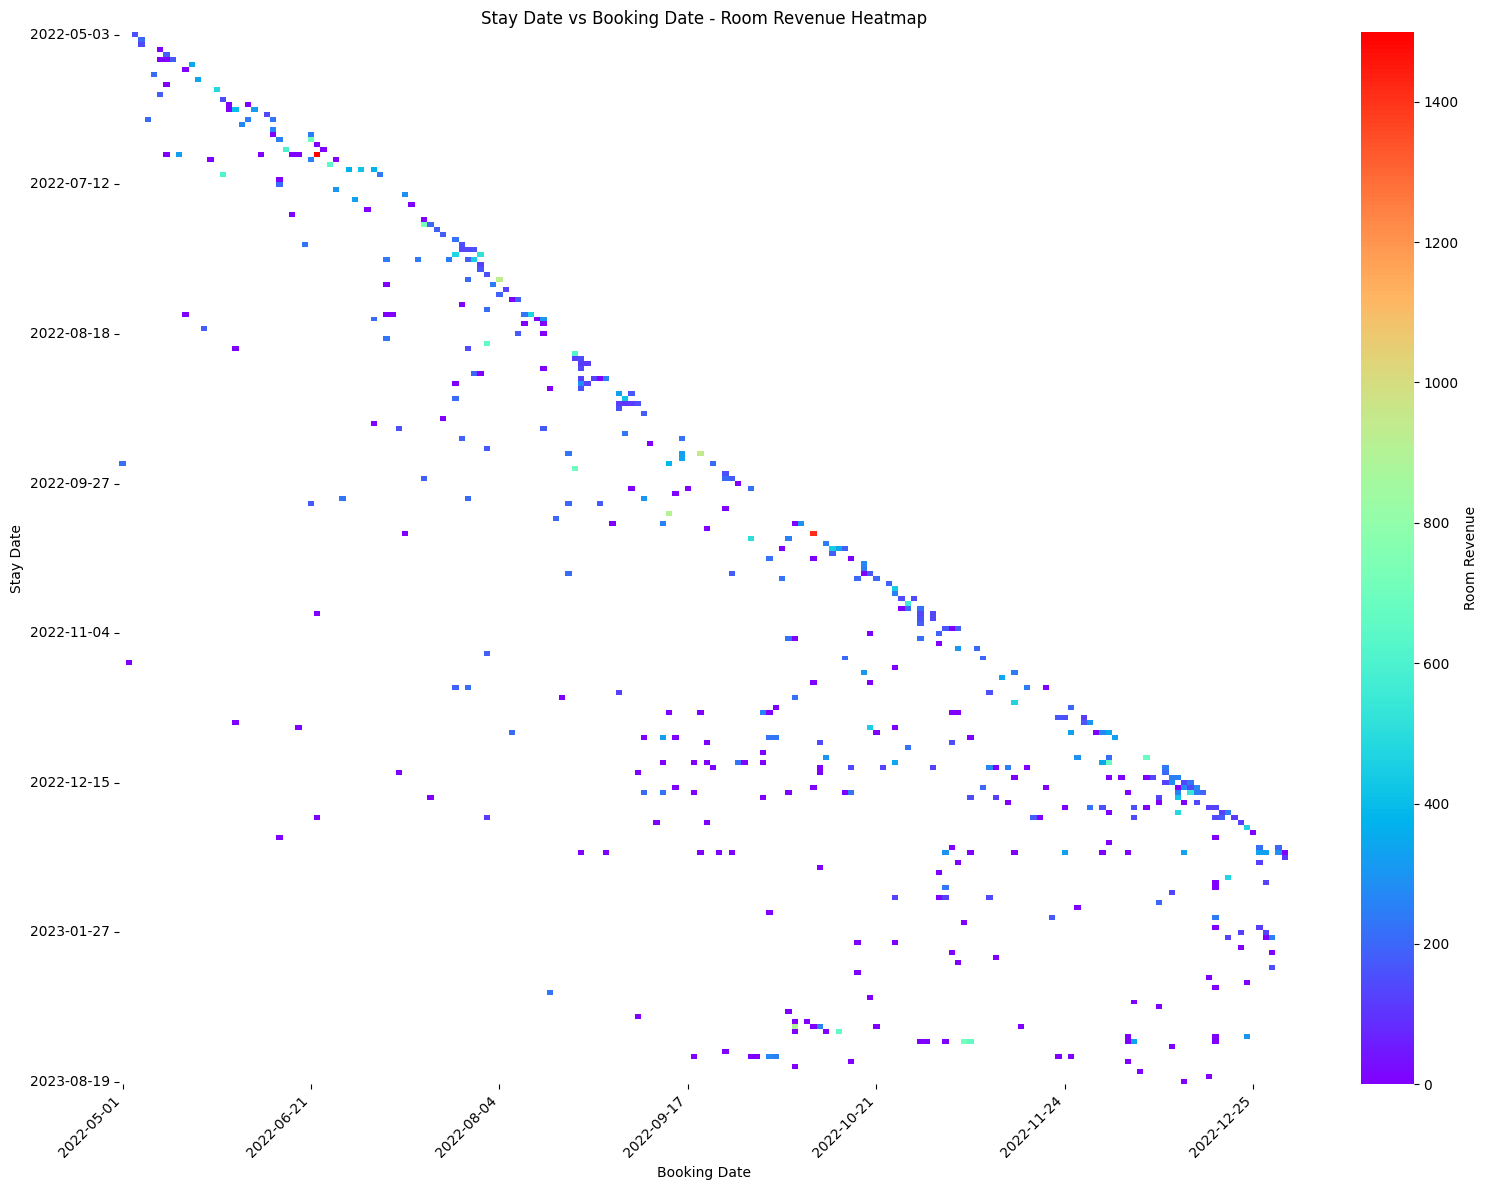

In [101]:

plot_revenue_heatmap(filtered_rates_data, start_date='2022-01-01', end_date='2022-12-31', cmap='rainbow')

In [103]:
# Create a new column for classification
filtered_rates_data['classification'] = 'No Match'

# Apply each mask to classify the points
filtered_rates_data.loc[match_refundable_vs_tax_discount, 'classification'] = 'Match Tax and Discount'
filtered_rates_data.loc[match_refundable_vs_tax_two_discounts, 'classification'] = 'Match Tax and Two Discounts'
filtered_rates_data.loc[match_refundable_vs_tax_discount_g2, 'classification'] = 'Match Tax and Discount G2'
filtered_rates_data.loc[match_refundable_vs_tax_discount_g2_and_app_discount, 'classification'] = 'Match Tax, Discount G2, and App Discount'
filtered_rates_data.loc[match_refundable_vs_tax_discount_g3, 'classification'] = 'Match Tax and Discount G3'
filtered_rates_data.loc[match_refundable_vs_tax_discount_g3_and_app_discount, 'classification'] = 'Match Tax, Discount G3, and App Discount'

# For points that match multiple categories, you can use a more specific classification
filtered_rates_data.loc[match_refundable_vs_tax_discount & match_refundable_vs_tax_two_discounts, 'classification'] = 'Match Multiple Categories'

# You can add more complex combinations as needed

# Count the number of points in each category
classification_counts = filtered_rates_data['classification'].value_counts()

print("Classification counts:")
print(classification_counts)

# Display a few rows to verify the classification
print("\nSample of classified data:")
print(filtered_rates_data[['refundable_rate', 'classification']].head(10))

Classification counts:
classification
No Match                                    1220
Match Tax and Discount                        93
Match Tax and Two Discounts                   79
Match Tax, Discount G2, and App Discount      35
Match Tax and Discount G3                     18
Match Tax and Discount G2                     18
Match Tax, Discount G3, and App Discount      14
Name: count, dtype: int64

Sample of classified data:
   refundable_rate          classification
0            309.0  Match Tax and Discount
1            369.0                No Match
2            229.0  Match Tax and Discount
3            279.0  Match Tax and Discount
4            199.0                No Match
5            199.0                No Match
6            279.0                No Match
7            199.0                No Match
8            199.0                No Match
9            199.0                No Match


/var/folders/7m/8y6jbsj56511tmcdmrpyjlrr0000gn/T/ipykernel_74426/145993374.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(pivot_data.replace(color_map.keys(), range(len(color_map))),


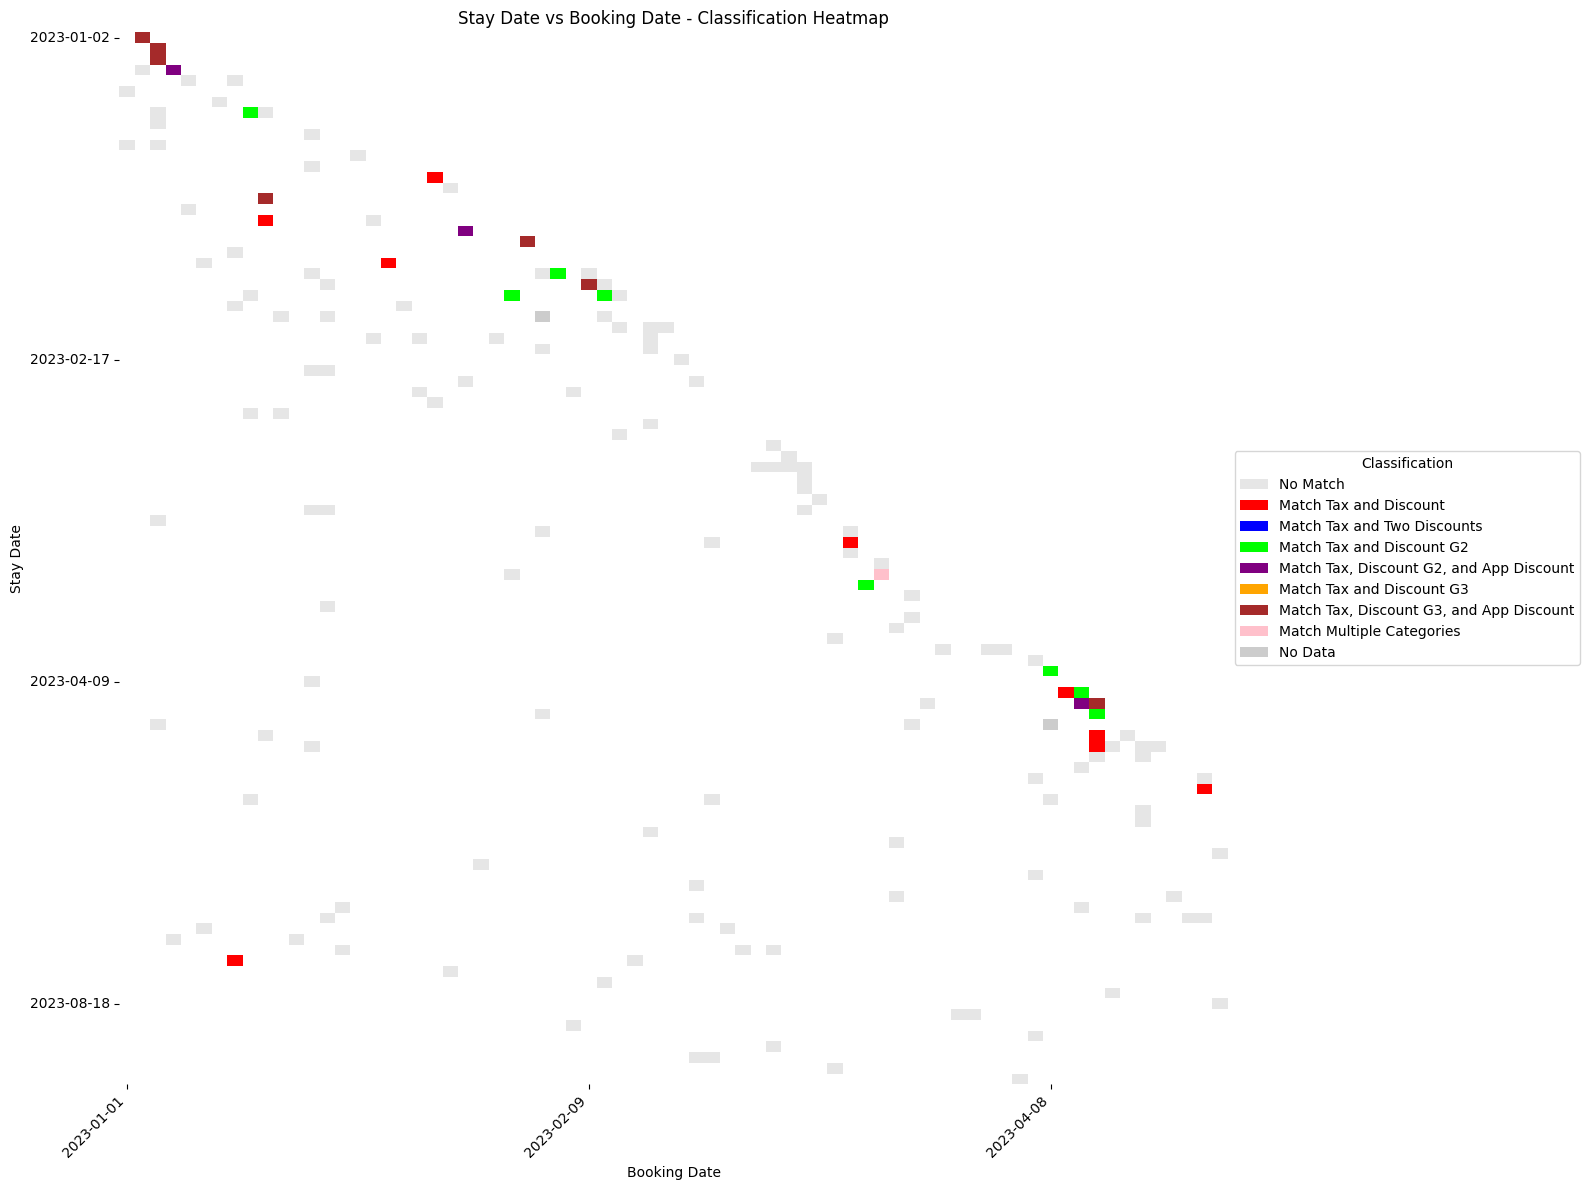

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_classification_heatmap(data, start_date=None, end_date=None, figsize=(16, 12)):
    """
    Plot a heatmap based on the classification of each point.
    """
    # Convert date columns to datetime if they're not already
    data['created_date'] = pd.to_datetime(data['created_date'])
    data['check_in'] = pd.to_datetime(data['check_in'])

    # Filter data based on booking date range if provided
    if start_date:
        start_date = pd.to_datetime(start_date)
        data = data[data['created_date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        data = data[data['created_date'] <= end_date]

    # Create a pivot table with classifications
    pivot_data = data.pivot_table(
        values='classification',
        index=data['check_in'].dt.to_period('D'),
        columns=data['created_date'].dt.to_period('D'),
        aggfunc=lambda x: x.mode().iat[0] if len(x) > 0 else 'No Data'
    )

    # Define colors for each classification
    color_map = {
        'No Match': '#E6E6E6',  # White
        'Match Tax and Discount': '#FF0000',  # Red
        'Match Tax and Two Discounts': '#0000FF',  # Blue
        'Match Tax and Discount G2': '#00FF00',  # Green
        'Match Tax, Discount G2, and App Discount': '#800080',  # Purple
        'Match Tax and Discount G3': '#FFA500',  # Orange
        'Match Tax, Discount G3, and App Discount': '#A52A2A',  # Brown
        'Match Multiple Categories': '#FFC0CB',  # Pink
        'No Data': '#CCCCCC'  # Light Gray
    }

    # Create a custom colormap
    cmap = sns.color_palette([color_map[cat] for cat in color_map.keys()])

    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(pivot_data.replace(color_map.keys(), range(len(color_map))),
                cmap=cmap,
                cbar=False,
                xticklabels=30,
                yticklabels=30,
                ax=ax)

    # Set labels and title
    ax.set_xlabel('Booking Date')
    ax.set_ylabel('Stay Date')
    ax.set_title('Stay Date vs Booking Date - Classification Heatmap')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='none') for color in color_map.values()]
    ax.legend(legend_elements, color_map.keys(), title='Classification', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

# Example usage:
plot_classification_heatmap(filtered_rates_data, start_date='2023-01-01', end_date='2023-04-20')

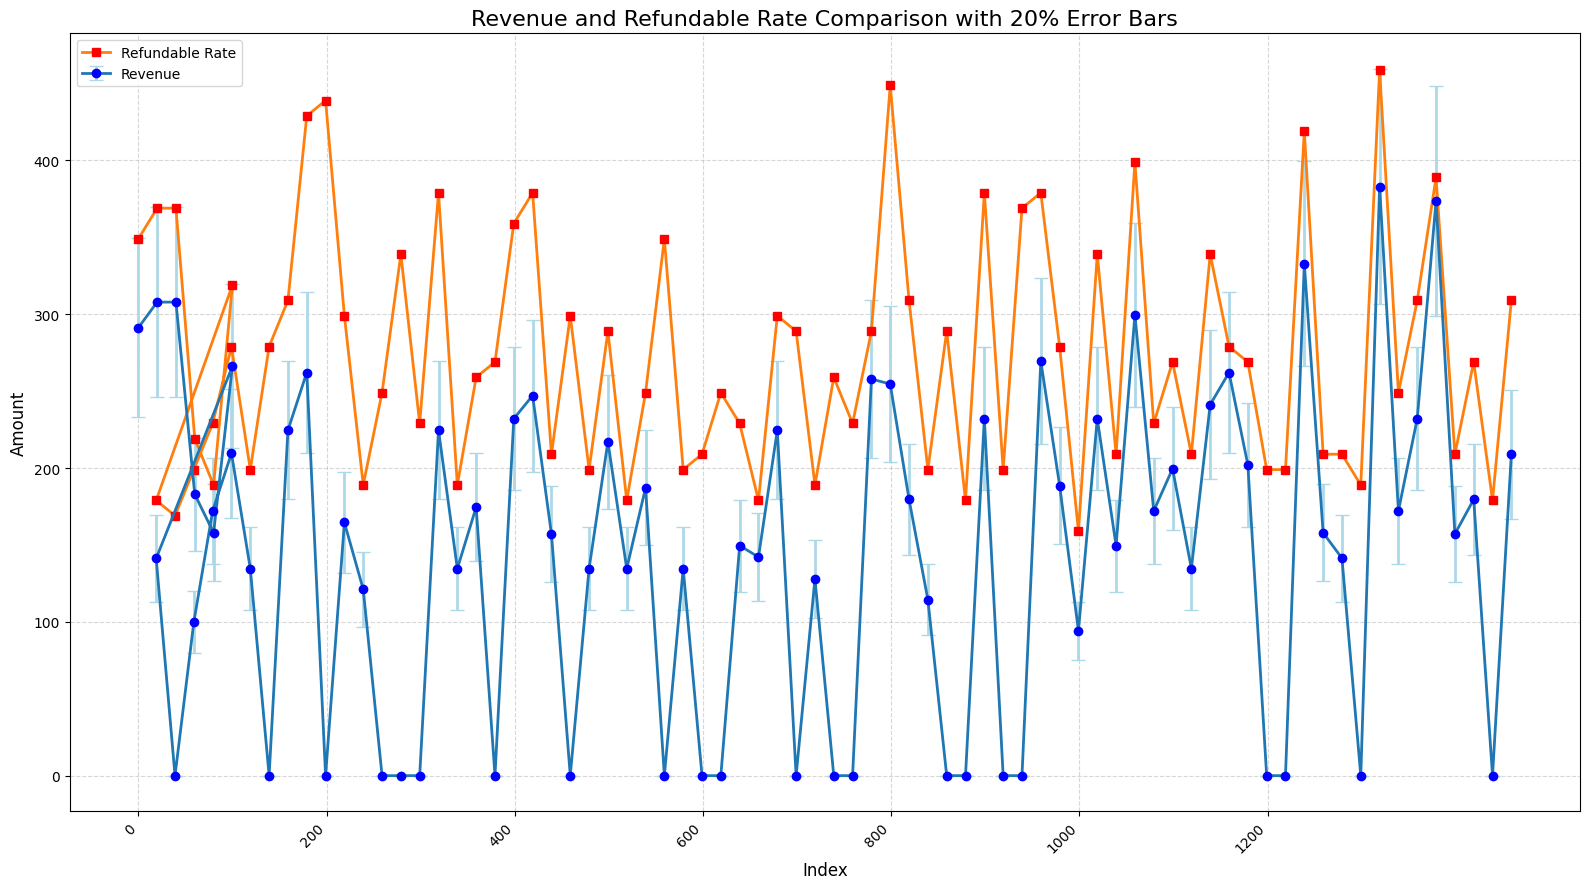

In [113]:
# Create the figure and axis objects
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(16, 9))

# Plot every 20th data point with markers and error bars
step = 20
indices = complete_rates_data.index[::step]
revenue = complete_rates_data['room_revenue'][::step]
refundable_rate = complete_rates_data['refundable_rate'][::step]

# Calculate error (20% of revenue)
error = revenue * 0.2

ax.errorbar(indices, revenue, yerr=error, 
            label='Revenue', linewidth=2, marker='o', markersize=6, linestyle='-',
            markerfacecolor='blue', markeredgecolor='blue', markeredgewidth=1,
            capsize=5, capthick=2, ecolor='lightblue')

ax.plot(indices, refundable_rate,
        label='Refundable Rate', linewidth=2, marker='s', markersize=6, linestyle='-',
        markerfacecolor='red', markeredgecolor='red', markeredgewidth=1)

# Customize the plot
ax.set_xlabel('Index', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_title('Revenue and Refundable Rate Comparison with 20% Error Bars', fontsize=16)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)

# Set x-axis ticks to show every 200th point
ax.set_xticks(np.arange(0, 1400, 200))
ax.set_xticklabels(np.arange(0, 1400, 200), rotation=45, ha='right')

# Add thousand separators to y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout and display
plt.tight_layout()
plt.show()

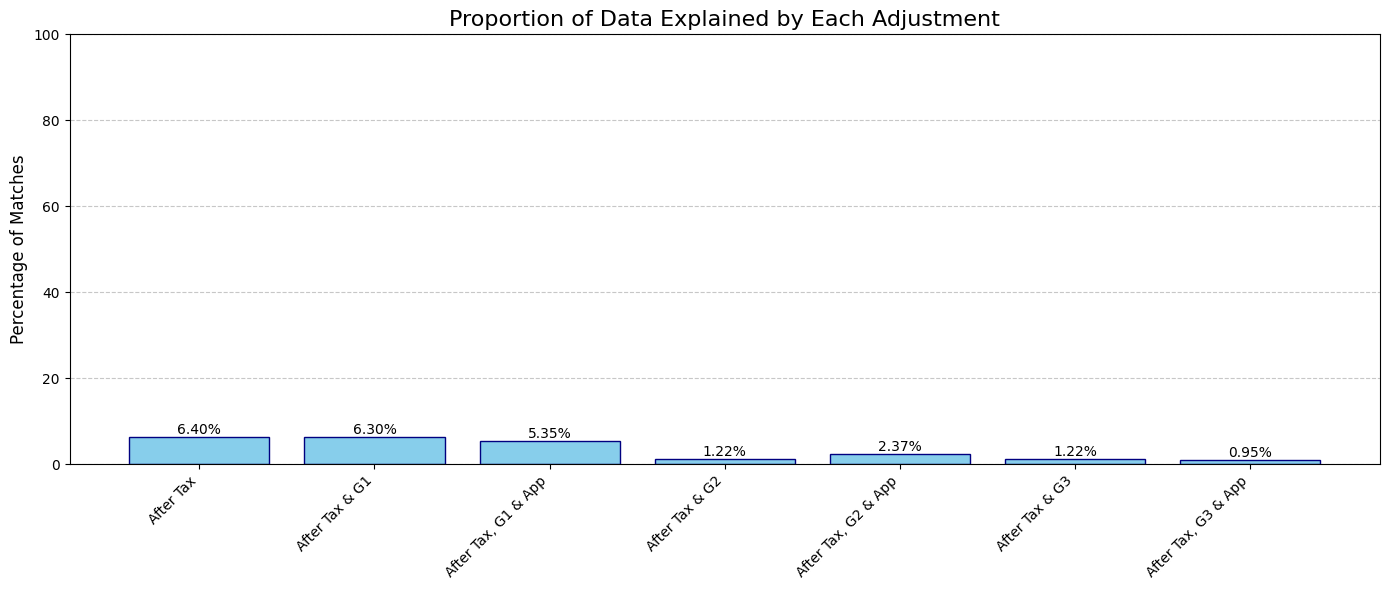

In [83]:
# Read the CSV file
df1 = pd.read_csv('matches_after_tax.csv')

# Data preparation
labels = [
    'After Tax',
    'After Tax & G1',
    'After Tax, G1 & App',
    'After Tax & G2',
    'After Tax, G2 & App',
    'After Tax & G3',
    'After Tax, G3 & App'
]

percentages = [
    len(df1)/len(complete_rates_data)*100,
    num_matches_tax_discount/len(rates_comparison_df)*100,
    num_matches_tax_two_discounts/len(rates_comparison_df)*100,
    num_matches_tax_discount_g2/len(rates_comparison_df)*100,
    num_matches_tax_discount_g2_and_app_discount/len(rates_comparison_df)*100,
    num_matches_tax_discount_g3/len(rates_comparison_df)*100,
    num_matches_tax_discount_g3_and_app_discount/len(rates_comparison_df)*100
]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create the histogram
bars = ax.bar(labels, percentages, color='skyblue', edgecolor='navy')

# Customize the plot
ax.set_ylabel('Percentage of Matches', fontsize=12)
ax.set_title('Proportion of Data Explained by Each Adjustment', fontsize=16)
ax.set_ylim(0, 100)  # Set y-axis from 0 to 100%

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a grid for easier reading
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()